# Initialization

In [75]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [76]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [77]:
seattle_2016 = pd.read_csv("/content/drive/My Drive/OpenClassrooms/PElec_fatmi_amine/2016-building-energy-benchmarking.csv")

# Explore dataset


In [78]:
seattle_2016.shape

(3376, 46)

In [79]:
seattle_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [80]:
seattle_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

There are nan values that would need to be treated later.

In [81]:
seattle_2016.describe(include='all')

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3376,3376,3376,3376,3376,3376,3360.000000,3376,3376.000000,3376,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3367,3356,3.356000e+03,1679,1679.000000,596,596.000000,119,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3376,0.0,3376,32,3367.000000,3367.000000
unique,NaN,NaN,8,24,3362,3354,1,1,NaN,3268,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,466,56,NaN,50,NaN,44,NaN,65,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,4,2,NaN,NaN
top,NaN,NaN,NonResidential,Low-Rise Multifamily,Northgate Plaza,309 South Cloverdale Street,Seattle,WA,NaN,1625049001,NaN,DOWNTOWN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Multifamily Housing,Multifamily Housing,NaN,Parking,NaN,Retail Store,NaN,2016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,Compliant,Low outlier,NaN,NaN
freq,NaN,NaN,1460,987,3,4,3376,3376,NaN,8,NaN,573,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,866,1667,NaN,976,NaN,110,NaN,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3263,NaN,3211,23,NaN,NaN
mean,21208.991114,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98116.949107,NaN,4.439277,NaN,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,NaN,NaN,7.917764e+04,NaN,28444.075817,NaN,11738.675166,NaN,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,NaN,NaN,NaN,119.723971,1.175916
std,12223.757015,0.0,NaN,NaN,NaN,NaN,NaN,NaN,18.615205,NaN,2.120625,NaN,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,NaN,NaN,2.017034e+05,NaN,54392.917928,NaN,29331.199286,NaN,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,NaN,NaN,NaN,538.832227,1.821452
min,1.000000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98006.000000,NaN,1.000000,NaN,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,NaN,NaN,5.656000e+03,NaN,0.000000,NaN,0.000000,NaN,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98105.000000,NaN,3.000000,NaN,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,NaN,NaN,2.509475e+04,NaN,5000.000000,NaN,2239.000000,NaN,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,9.495000,0.210000
50%,23112.000000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98115.000000,NaN,4.000000,NaN,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,NaN,NaN,3.989400e+04,NaN,10664.000000,NaN,5043.000000,NaN,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,NaN,NaN,NaN,33.920000,0.610000
75%,25994.250000,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,98122.000000,NaN,7.000000,NaN

Some columns have little to no variability (DataYear, City, State,...). Some others have little interest for the analysis like BuildingID. I will address them later in the cleaning section.

In [82]:
seattle_2016['Neighborhood'].value_counts()

DOWNTOWN                  573
EAST                      453
MAGNOLIA / QUEEN ANNE     423
GREATER DUWAMISH          375
NORTHEAST                 280
LAKE UNION                251
NORTHWEST                 210
SOUTHWEST                 166
NORTH                     145
BALLARD                   126
CENTRAL                   107
SOUTHEAST                  95
DELRIDGE                   80
North                      42
Central                    27
Northwest                  11
Ballard                     7
Delridge                    4
DELRIDGE NEIGHBORHOODS      1
Name: Neighborhood, dtype: int64

Let's clean this column.

In [83]:
seattle_2016['Neighborhood'] = seattle_2016['Neighborhood'].str.upper()
seattle_2016['Neighborhood'] = seattle_2016['Neighborhood'].str.replace('DELRIDGE NEIGHBORHOODS', 'DELRIDGE')
seattle_2016['Neighborhood'].value_counts()

DOWNTOWN                 573
EAST                     453
MAGNOLIA / QUEEN ANNE    423
GREATER DUWAMISH         375
NORTHEAST                280
LAKE UNION               251
NORTHWEST                221
NORTH                    187
SOUTHWEST                166
CENTRAL                  134
BALLARD                  133
SOUTHEAST                 95
DELRIDGE                  85
Name: Neighborhood, dtype: int64

We can now easily visualize these neighborhoods using latitude and longitude data.

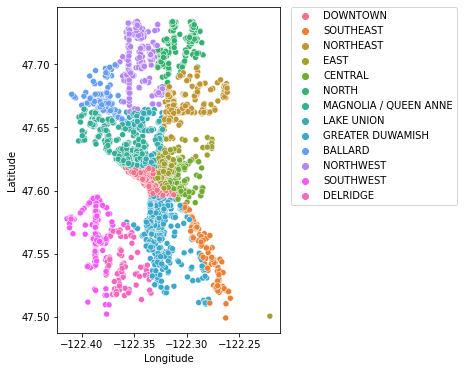

In [84]:
plt.figure(figsize=(4,6))
sns.scatterplot(x=seattle_2016['Longitude'],y=seattle_2016['Latitude'],  hue=seattle_2016['Neighborhood'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

It looks great! Each neighborhood is clearly clustered. We don't have mixed colors which is good point and gives us more confidence on the data. However, we have got a point that is clearly apart (long > -122.25). This point will be removed during the data cleaning.

In [85]:
seattle_2016[seattle_2016['Longitude'] > -122.25]

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
3084,29069,2016,Multifamily LR (1-4),Senior Care Community,Lakeshore,11448 Rainier Ave S,Seattle,WA,98178.0,1180001715,3,EAST,47.500619,-122.220966,1995,1.0,3,124930,0,124930,Senior Care Community,Senior Care Community,132284.0,Senior Care Community,132284.0,NaN,NaN,NaN,98.0,50.799999,52.799999,121.599999,126.300003,6723971.5,6987057.0,0.0,1265544.0,4318036.0,24059.34961,2405935.0,True,NaN,Error - Correct Default Data,NaN,157.88,1.26


We can proceed the same way using the CouncilDistrictCode variable instead of Neighborhood.

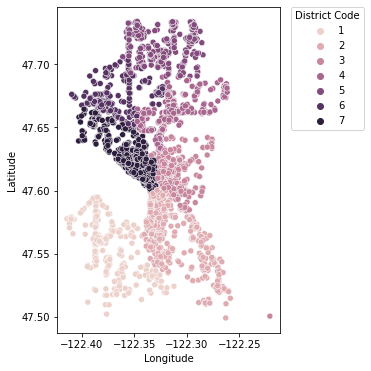

In [86]:
plt.figure(figsize=(4,6))
sns.scatterplot(x=seattle_2016['Longitude'],y=seattle_2016['Latitude'],  hue=seattle_2016['CouncilDistrictCode'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title='District Code')

Let's now have a quick look at the continuous variables distributions using histplot.

In [87]:
col_continuous = ['PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore',
       'SiteEnergyUse(kBtu)',
       'TotalGHGEmissions']

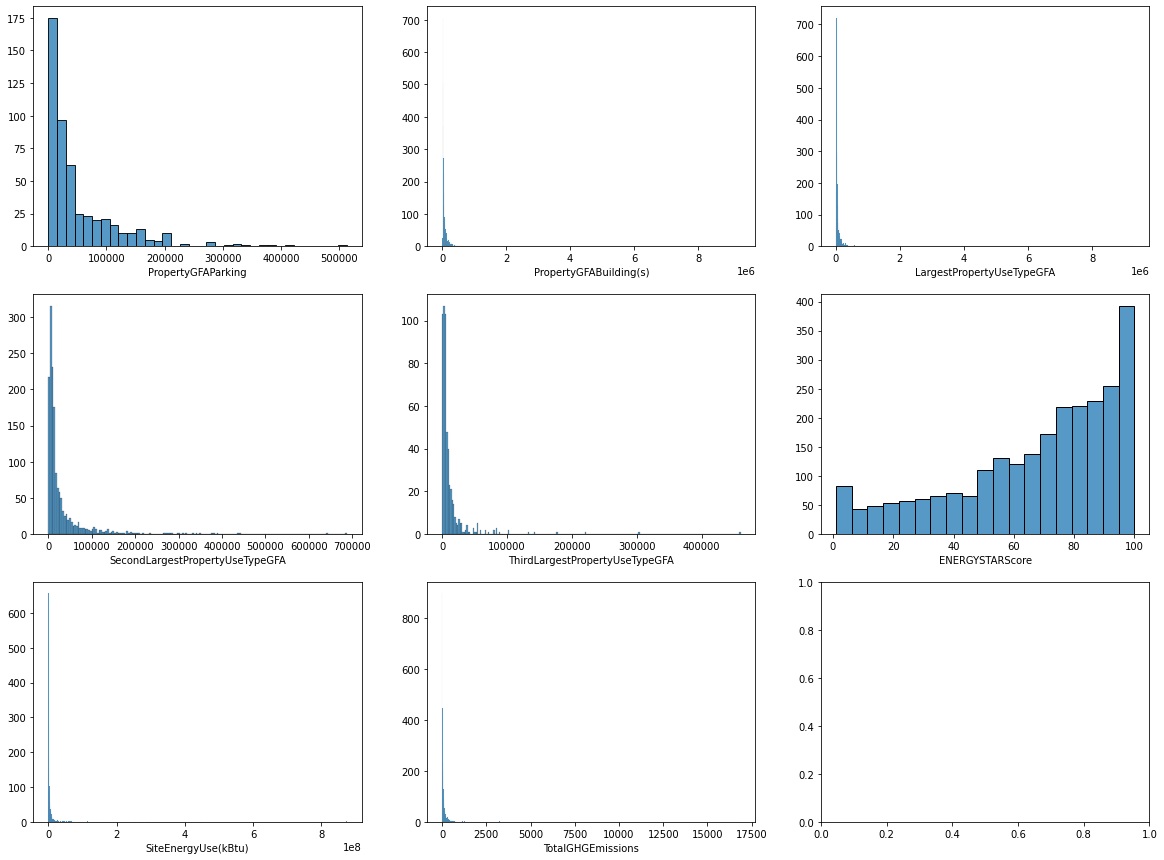

In [88]:
fig, axes = plt.subplots(3,3, figsize=(20,15))
y=0
for col in col_continuous:
    i,j = divmod(y,3)
    sns.histplot(ax = axes[i,j], x=seattle_2016[col].replace(0, np.nan))
    axes[i,j].set_title('')
    axes[i,j].set_ylabel('')   
    axes[i,j].set_xlabel(col) 

    y=y+1

Apart from ENERGYSTARScore, all these columns are badly right skewed. There are far from looking to a normal distribution. We will see later in the feature engineering section how we can treat that.

We check now the correlation between numerical continuous variables. Based on the skewed distributions, I will be using Spearman method rather than Pearson to compute the correlation coefficients.

In [89]:
col_numerical = ['PropertyGFAParking',
       'PropertyGFABuilding(s)', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SourceEUI(kBtu/sf)',
       'SiteEnergyUse(kBtu)', 'SteamUse(kBtu)',
       'Electricity(kBtu)', 'NaturalGas(kBtu)',
       'TotalGHGEmissions']

[Text(0.5, 0, 'PropertyGFAParking'),
 Text(1.5, 0, 'PropertyGFABuilding(s)'),
 Text(2.5, 0, 'LargestPropertyUseTypeGFA'),
 Text(3.5, 0, 'SecondLargestPropertyUseTypeGFA'),
 Text(4.5, 0, 'ThirdLargestPropertyUseTypeGFA'),
 Text(5.5, 0, 'ENERGYSTARScore'),
 Text(6.5, 0, 'SourceEUI(kBtu/sf)'),
 Text(7.5, 0, 'SiteEnergyUse(kBtu)'),
 Text(8.5, 0, 'SteamUse(kBtu)'),
 Text(9.5, 0, 'Electricity(kBtu)'),
 Text(10.5, 0, 'NaturalGas(kBtu)'),
 Text(11.5, 0, 'TotalGHGEmissions')]

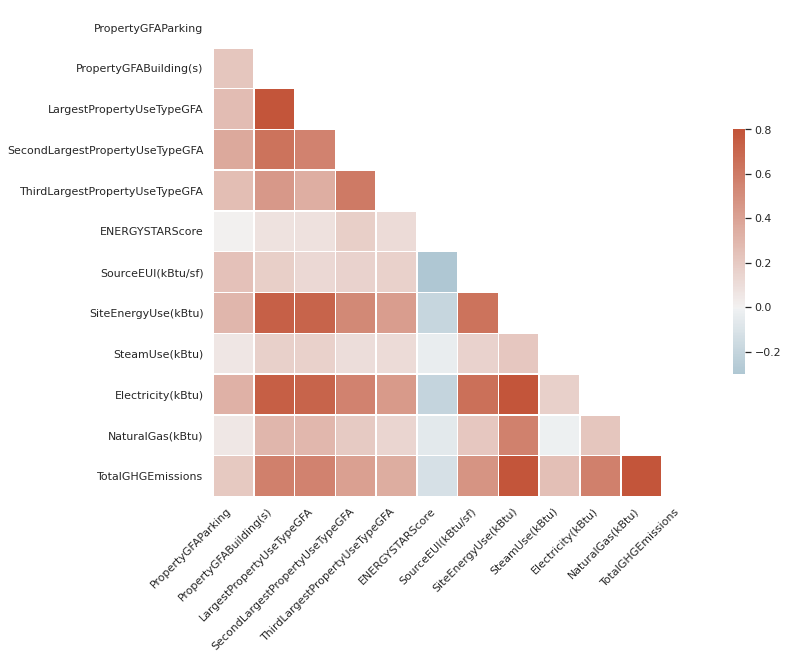

In [90]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = seattle_2016[col_numerical].corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0, vmin=-.3,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [91]:
corr[['SiteEnergyUse(kBtu)', 'TotalGHGEmissions']]

,SiteEnergyUse(kBtu),TotalGHGEmissions
PropertyGFAParking,0.304340,0.208116
PropertyGFABuilding(s),0.738289,0.574299
LargestPropertyUseTypeGFA,0.719174,0.565221
SecondLargestPropertyUseTypeGFA,0.535014,0.415350
ThirdLargestPropertyUseTypeGFA,0.428965,0.353313
ENERGYSTARScore,-0.190916,-0.117516
SourceEUI(kBtu/sf),0.642979,0.474122
SiteEnergyUse(kBtu),1.000000,0.874750
SteamUse(kBtu),0.215741,0.255468
Electricity(kBtu),0.861852,0.573463


Few observations:
  - both target variables are highly correlated (SEU and GHGE)
  - Electricity(kBtu) is the most correlated to SEU (after GHGE)
  - NaturalGas(kBtu) is the most correlated to GHGE (after SEU)

This is what we expected. But we won't spend much time exploring measured variables (SourceEU, Steam, Electricity and Gas) as we should avoid them for the predictions.

More interestingly for our analysis, PropertyGFABuilding(s) and LargestPropertyUseTypeGFA are highly correlated to both targets! They would be with no doubts good predictors.

EnergyStarScore which measures the performance of a building is the only variable anti-correlated to both targets.


PropertyName and TaxParcel variables have too much variability (few unique values)  --> Not used

Adress variable has too much variability. However, if we keep the street name only it might be interesting --> formatting using regex.

Remove the Outlier variable. Don't know on which criteria the low and high outlier values were defined. There is too much NaN also.

ComplianceStatus variable --> Keep only the rows with 'compliant' value. (= met energy benchmarking requirements for the current year)

Electricity(kBtu) and TotalGHGE min value is < 0 which is not possible.

Check that:

GFATotal >= LargestGFA1 + LargestGFA2 + LargestGFA3 --> remove all observations that are not compliant with this criteria.

# Cleaning

In [92]:
seattle_2016['BuildingType'].value_counts()

NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: BuildingType, dtype: int64

In [93]:
# clean BuildingType column
seattle_2016['BuildingType'] = seattle_2016['BuildingType'].str.replace('Nonresidential WA', 'NonResidential')
seattle_2016['BuildingType'].value_counts()

NonResidential          1461
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Name: BuildingType, dtype: int64

In [94]:
seattle_2016['Outlier'].value_counts()

Low outlier     23
High outlier     9
Name: Outlier, dtype: int64

In [95]:
seattle_2016['ComplianceStatus'].value_counts()

Compliant                       3211
Error - Correct Default Data     113
Non-Compliant                     37
Missing Data                      15
Name: ComplianceStatus, dtype: int64

Outlier variable has mainly nan values. And I don't know on what basis these 32 observations were categorized as outliers (low and high). I decide to drop these columns and treat outliers differently.

Regarding the CompliantStatus variable I will only keep the observations that are compliant and then drop this column.

In [96]:
# filter df by keeping only compliant samples.
seattle_2016 = seattle_2016[seattle_2016['ComplianceStatus'] == 'Compliant']

I have selected a list of columns to drop based on the following criteria:
  - low variability
  - little interest for the analysis
  - measurement data (not to be used for predictions)
  - column already filtered and not useful anymore

In [97]:
drop_col = ['DataYear', 'City', 'State','SiteEUI(kBtu/sf)',
       'SiteEUIWN(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
        'SiteEnergyUseWN(kBtu)', 'YearsENERGYSTARCertified',
       'Electricity(kWh)', 'NaturalGas(therms)', 'SourceEUI(kBtu/sf)',
        'Comments', 'GHGEmissionsIntensity','OSEBuildingID', 'PropertyName',
       'TaxParcelIdentificationNumber',
       'Latitude', 'Longitude',  'ListOfAllPropertyUseTypes',
       'DefaultData', 'ComplianceStatus', 'Outlier']

In [98]:
# drop columns from the df
seattle_2016 = seattle_2016.drop(drop_col, axis=1)

In [99]:
seattle_2016.shape

(3211, 24)

I will now check the consistency of the dataset using GFA columns. First, I need to address nan values from Second and Third LargestPropertyUseType. It is mainly the case when there is only 1 BuildingType for the sample. I have then decided to fill in the missing values with 'None' for PropertyUseType and '0' for corresponding GFA. 

In [100]:
# fill missing values
seattle_2016[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']] = \
                      seattle_2016[['SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType']].fillna('None')
seattle_2016[['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']] = \
                    seattle_2016[['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA']].fillna(0)

PropertyGFATotal is necessarily greater than the sum of the 3 largest property use type. I will then filter the df by removing all rows that are not compliant with this statement. 

In [101]:
# filter df using PropertyGFATotal and 3 PropertyUseTypeGFA
seattle_2016 = seattle_2016[seattle_2016['PropertyGFATotal'] >= \
             seattle_2016['LargestPropertyUseTypeGFA'] + seattle_2016['SecondLargestPropertyUseTypeGFA'] \
             + seattle_2016['ThirdLargestPropertyUseTypeGFA']]

In [102]:
seattle_2016.shape

(2470, 24)

After applying the filter above, we get rid off almost 800 observations!

Let's check that PropertyGFATotal is equal to GFABuilding + GFAParking

In [103]:
seattle_2016[
             seattle_2016['PropertyGFATotal'] != \
             seattle_2016['PropertyGFABuilding(s)'] + seattle_2016['PropertyGFAParking']
]

,BuildingType,PrimaryPropertyType,Address,ZipCode,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions


Nothing to filter here. We will just drop PropertyGFATotal as it is useless. GFAPArking and GFABuilding are enough.

In [104]:
# drop PropertyGFATotal column
seattle_2016 = seattle_2016.drop('PropertyGFATotal', axis=1)
seattle_2016.shape

(2470, 23)

GHGEmissions can't have negative value.

In [105]:
seattle_2016['TotalGHGEmissions'].describe()

count     2470.000000
mean        92.587000
std        336.212509
min         -0.800000
25%          8.850000
50%         30.300000
75%         80.250000
max      11140.560000
Name: TotalGHGEmissions, dtype: float64

In [106]:
# remove negative emissions from the df
seattle_2016 = seattle_2016[seattle_2016['TotalGHGEmissions'] >= 0]

In [107]:
seattle_2016.shape

(2469, 23)

#Feature Engineering

## Address

In [108]:
# extract house number and street name from address
import re
pattern=r'^(\d+[-]\d+|\d+)(.*)'
house_street = seattle_2016['Address'].str.upper().str.extract(pattern)

In [109]:
house_street[1]

0          OLIVE WAY
1        PINE STREET
2         5TH AVENUE
3         STEWART ST
5        VIRGINIA ST
            ...     
3370     34TH AVE SW
3372       8TH AVE S
3373       1ST AVE W
3374       8TH AVE S
3375     S MYRTLE ST
Name: 1, Length: 2469, dtype: object

In [110]:
# create new variables to store these data
seattle_2016['HouseNumber'] = house_street[0]
seattle_2016['StreetName'] = house_street[1]

Now, let's check StreetName variable to check most common names.

In [111]:
street_list = pd.Series(seattle_2016['StreetName'].dropna().str.split(r'\s'))
list_street = [element for list_ in street_list for element in list_]
pd.Series(list_street).value_counts()[:20]

          2477
AVE       1063
NE         340
ST         331
S          294
AVENUE     267
N          253
WAY        238
E          211
STREET     171
SW         164
AVE.       148
W          120
1ST        105
NW         103
SOUTH       98
ST.         77
S.          57
4TH         55
2ND         54
dtype: int64

Let's clean the StreetName column using regex.

In [112]:
street_dict = { 'AVE': 'AVENUE', 'AV':'AVENUE','ST':'STREET', 'ST.':'STREET', 'NORTH':'', 'SOUTH':'', 'EAST':'', 'WEST':'',
               'S.':'', 'N.':'', 'E.':'', 'W.':'', 'N.E.':'NE', 'S.W.':'SW', 'N.W.':'NW', 'SO.':'SO', 'NORTHWEST':'',
               'S':'', 'N':'', 'W':'', 'E':'',
               'FIRST':'1ST', 'SECOND':'2ND', 'THIRD':'3RD', 'FOURTH':'4TH', 'FIFTH':'5TH', 'SIXTH':'6TH','SEVENTH':'7TH','EIGHTH':'8TH', 'NINTH':'9TH', 'TWELFTH':'12TH',
               '&':'AND', 'M L KING JR WAY':'MARTIN LUTHER KING JR WAY', 'MLK JR WAY':'MARTIN LUTHER KING JR WAY', '- 3RD AVENUE':'3RD AVENUE',
               '- ':''}
test_regex = seattle_2016['StreetName']
test_regex = test_regex.str.strip()

for key, value in street_dict.items():
  test_regex=test_regex.str.replace(r'\b{}\b'.format(key), value, regex=True)

test_regex = test_regex.replace(r'[.]', '', regex=True)
test_regex = test_regex.replace(r'[-]', '', regex=True)
test_regex = test_regex.replace(r'[,]', '', regex=True)
test_regex = test_regex.replace(r'\bROOM\b[\s*\d*\w*]', '', regex=True)
test_regex = test_regex.replace(r'\SUITE\b[\s*\d*\w*]', '', regex=True)
test_regex = test_regex.replace(r'[#][\s*\d*\w*]', '', regex=True)
test_regex = test_regex.replace(r'\bAPT\b\s*[\d*\w*]', '', regex=True)
test_regex = test_regex.replace(r'[/][\d+]', '', regex=True)
test_regex = test_regex.replace(r'\d+$', '', regex=True)
test_regex = test_regex.replace(r'[&][\s*\d*]\s*\d*', '', regex=True)
test_regex = test_regex.replace(r'^\s*\d+\s+', '', regex=True)
test_regex = test_regex.replace(r'([&]|\bAND\b)\s*\d*', '', regex=True)
test_regex = test_regex.str.replace(r'[(].*[)]', '', regex=True)
test_regex = test_regex.str.replace(r'\bAVENUE\b.*', 'AVENUE', regex=True)
test_regex = test_regex.str.replace(r'[/]\s*\d*', '', regex=True)


test_regex = test_regex.str.strip() 
test_regex.value_counts()[:50] 

1ST AVENUE           122
4TH AVENUE            64
2ND AVENUE            62
3RD AVENUE            55
5TH AVENUE            53
6TH AVENUE            48
15TH AVENUE           42
GREENWOOD AVENUE      41
8TH AVENUE            39
CALIFORNIA AVENUE     38
RAINIER AVENUE        29
12TH AVENUE           28
WESTERN AVENUE        28
AURORA AVENUE         27
11TH AVENUE           26
QUEEN ANNE AVENUE     25
BELLEVUE AVENUE       25
EASTLAKE AVENUE       25
MARGINAL WAY          25
ROOSEVELT WAY         23
PINE STREET           22
7TH AVENUE            22
9TH AVENUE            21
WESTLAKE AVENUE       21
TERRY AVENUE          19
AIRPORT WAY           19
LAKE CITY WAY         19
SUMMIT AVENUE         18
ELLIOTT AVENUE        18
ALKI AVENUE           18
MERCER STREET         17
14TH AVENUE           16
UNIVERSITY WAY        16
PIKE STREET           15
BOYLSTON AVENUE       15
ROY STREET            15
HARVARD AVENUE        15
13TH AVENUE           15
MINOR AVENUE          15
17TH AVENUE           15


1ST to 6TH avenue are the most common street names within the dataset which is not surprising.

In [113]:
seattle_2016['StreetName'] = test_regex
seattle_2016['StreetName'].value_counts()

1ST AVENUE     122
4TH AVENUE      64
2ND AVENUE      62
3RD AVENUE      55
5TH AVENUE      53
              ... 
52ND AVENUE      1
MEAD STREET      1
80TH             1
3RD  AVENUE      1
LYNN STREET      1
Name: StreetName, Length: 467, dtype: int64

## YearBuilt Binning

I will create another YearBuilt variable by binning the current variable. I will then encode this variable using OrdinalEncoder to preserve the ordinality.

In [114]:
# define bins where to cut
bins = [1898, 1915, 1930, 1950, 1965, 1980, 1995, 2005, 2015]
# define labels of newly created bins
labels = [ 1915, 1930, 1950, 1965, 1980, 1995, 2005, 2015]

year_binned = pd.cut(seattle_2016['YearBuilt'], bins=bins, labels=labels)

In [115]:
year_binned.value_counts()

1980    444
1995    409
2005    346
1930    322
1965    313
1915    273
2015    256
1950    106
Name: YearBuilt, dtype: int64

We have 256 data points between 2005 and 2015, 346 data points between 1995 and 2005, etc...

Let's replace these 'binned dates' with OrdinalEncoder

In [116]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
year_encoded = encoder.fit_transform(np.array(year_binned).reshape(-1,1)) # reshape(-1,1) to specify it's a column (not a row)
year_encoded[:10]

array([[1.],
       [6.],
       [4.],
       [1.],
       [6.],
       [1.],
       [1.],
       [0.],
       [0.],
       [4.]])

In [117]:
# assign the new variable to the dataset 
seattle_2016['YearBuilt_binned'] = year_encoded

## Log Transformation

Remember that our continuous variables were mostly badly skewed. It's time to fix that using log transformation. This will reduce the variability between high values and low values.

In [118]:
for col in col_continuous:
  if col != 'ENERGYSTARScore':
    seattle_2016[col] = np.log(seattle_2016[col]+1) 

# log(x+1) to avoid returning an error when x=0 and keep values > 0 (log(1)=0)

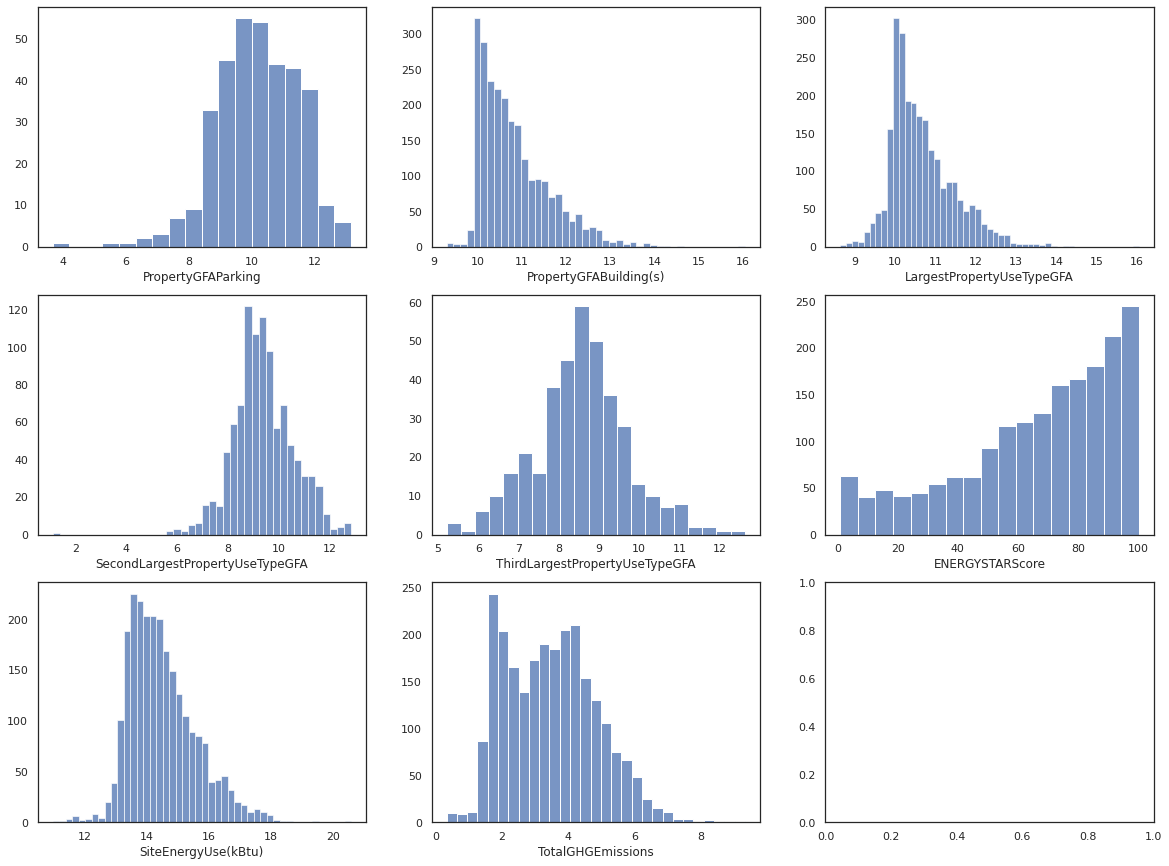

In [119]:
# plot distributions for continuous variables

fig, axes = plt.subplots(3,3, figsize=(20,15))
y=0
for col in col_continuous:
    i,j = divmod(y,3)
    sns.histplot(ax = axes[i,j], x=seattle_2016[col].replace(0, np.nan))
    axes[i,j].set_title('')
    axes[i,j].set_ylabel('')   
    axes[i,j].set_xlabel(col) 

    y=y+1

Our distributions are more like a Gaussian now. Let's move on and check some boxplots to visualize outliers.

## Outliers

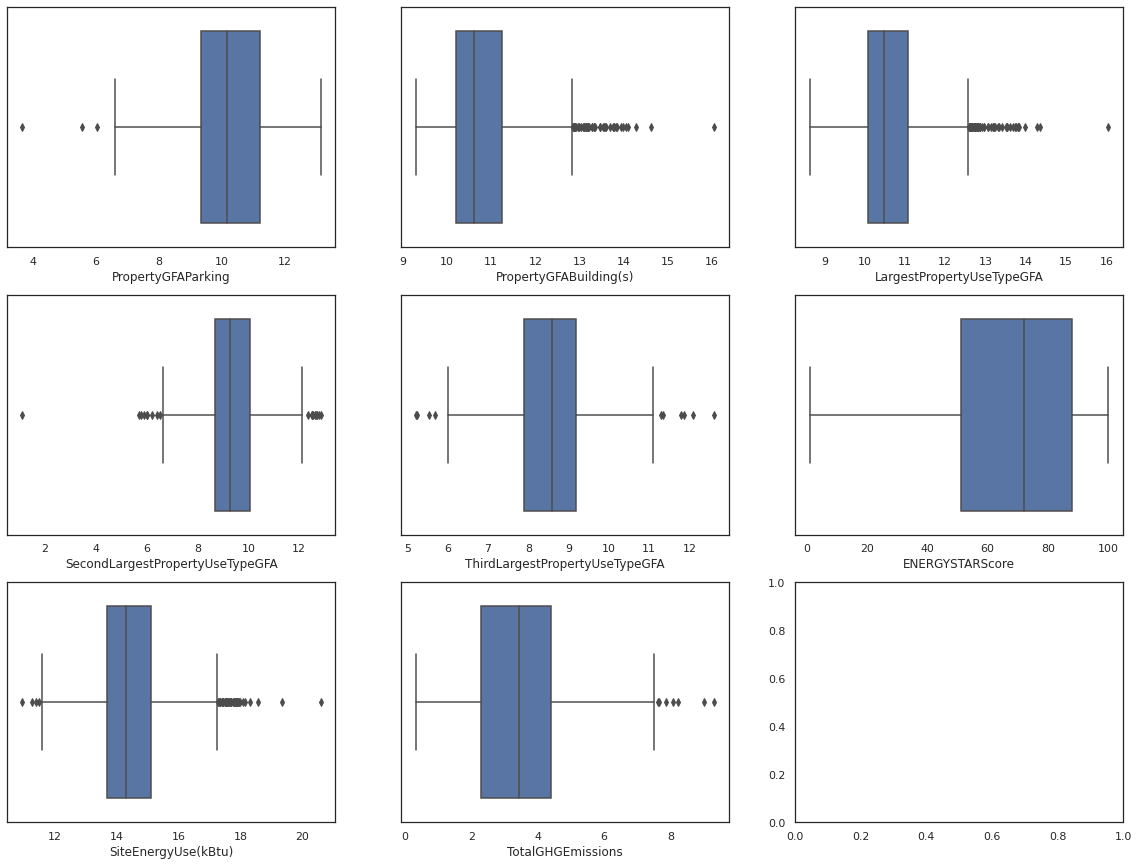

In [120]:
fig, axes = plt.subplots(3,3, figsize=(20,15))
y=0
for col in col_continuous:
    i,j = divmod(y,3)
    sns.boxplot(ax = axes[i,j], x=seattle_2016[col].replace(0, np.nan))
    axes[i,j].set_title('')
    axes[i,j].set_ylabel('')   
    axes[i,j].set_xlabel(col) 

    y=y+1

I have decided mainly not to treat the outliers that we see in the different boxplots. 

These outliers just means that we have less very large buldings that normal sized buildings. I would like the model to be able to predict them as well. 

In [121]:
seattle_2016['NumberofBuildings'].value_counts()

1.0      2347
0.0        68
2.0        20
3.0         9
4.0         7
5.0         7
10.0        2
14.0        2
6.0         2
111.0       1
23.0        1
16.0        1
8.0         1
11.0        1
Name: NumberofBuildings, dtype: int64

Furthermore this is consistent with the Numberofbuilding variable. it appears that most of the observations have 1 building only.

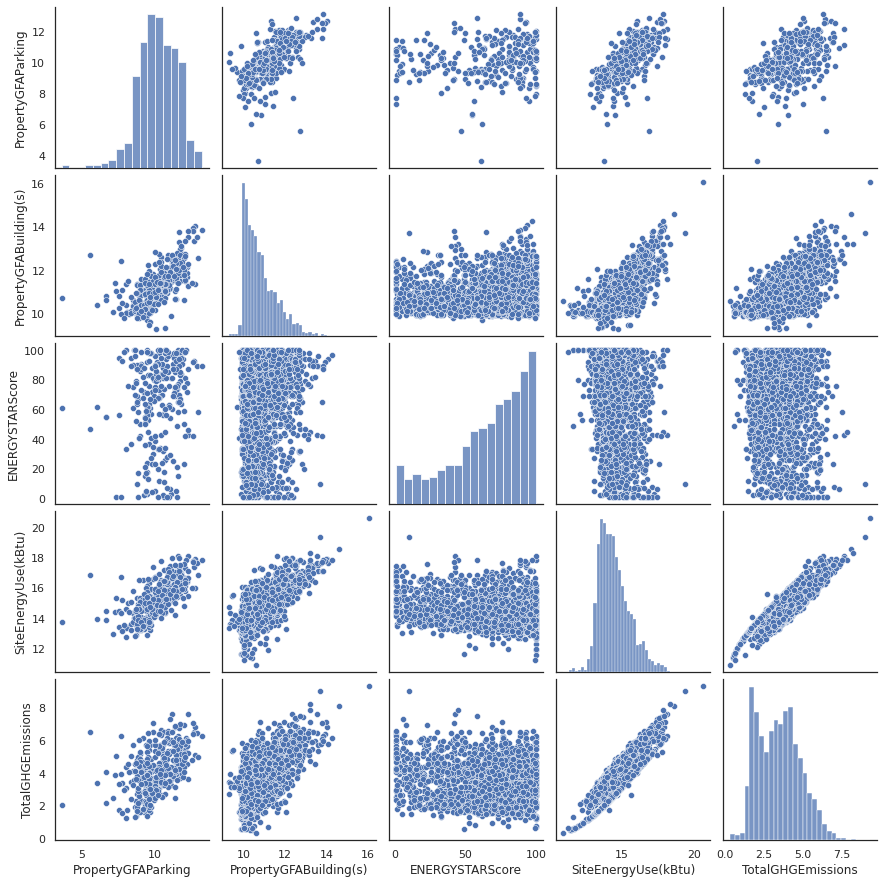

In [122]:
sns.pairplot(seattle_2016[[
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'ENERGYSTARScore', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']].replace(0, np.nan))

We can visually see the correlations between variables with the pairplot above. SEU and GHGE are highly linearly correlated. SEU is correlated with GFABuilding and Parking. It is not obvious that we have outliers when we look at SEU vs GFAParking.

Regarding SEU vs GFA Building, apart from two data points at the bottom of the graph the other data looks consistent.

In [123]:
seattle_2016.isnull().sum()

BuildingType                         0
PrimaryPropertyType                  0
Address                              0
ZipCode                             13
CouncilDistrictCode                  0
Neighborhood                         0
YearBuilt                            0
NumberofBuildings                    0
NumberofFloors                       0
PropertyGFAParking                   0
PropertyGFABuilding(s)               0
LargestPropertyUseType               0
LargestPropertyUseTypeGFA            0
SecondLargestPropertyUseType         0
SecondLargestPropertyUseTypeGFA      0
ThirdLargestPropertyUseType          0
ThirdLargestPropertyUseTypeGFA       0
ENERGYSTARScore                    629
SiteEnergyUse(kBtu)                  0
SteamUse(kBtu)                       0
Electricity(kBtu)                    0
NaturalGas(kBtu)                     0
TotalGHGEmissions                    0
HouseNumber                          3
StreetName                           3
YearBuilt_binned         

In [124]:
# drop the two highest values in PropertyGFABuilding (> 14.5)
seattle_2016 = seattle_2016[seattle_2016['PropertyGFABuilding(s)'] <= 14.5]

In [125]:
seattle_2016.shape

(2467, 26)

In [126]:
seattle_2016.isnull().sum().sort_values(ascending=False)[:4]

ENERGYSTARScore    627
ZipCode             13
HouseNumber          2
StreetName           2
dtype: int64

First let's drop Address and HouseNumber. Then we impute missig values for ZipCode and StreetName with most frequent value.

In [127]:
seattle_2016 = seattle_2016.drop(['HouseNumber', 'Address'], axis=1)

In [128]:
seattle_2016['ZipCode'].replace(np.nan, 98109, inplace=True)

In [129]:
seattle_2016['StreetName'].replace(np.nan, '1ST AVENUE', inplace=True)

We will impute the missing values for ENERGYSTARScore with a KNN imputer. I will do that after the train/test split to avoid any data leakage.

In [130]:
seattle_2016.shape

(2467, 24)

## Energy column

I will create 3 binary variables which take:


*   1 if building connected to gas (resp. elec and steam)
*   0 if not




In [132]:
seattle_2016['steam_cat'] = pd.Series(np.where(seattle_2016['SteamUse(kBtu)'].values==0,0,1), seattle_2016.index)
seattle_2016['gas_cat'] = pd.Series(np.where(seattle_2016['NaturalGas(kBtu)'].values==0,0,1), seattle_2016.index)
seattle_2016['elec_cat'] = pd.Series(np.where(seattle_2016['Electricity(kBtu)'].values==0,0,1), seattle_2016.index)

In [133]:
seattle_2016['steam_cat'].value_counts()

0    2378
1      89
Name: steam_cat, dtype: int64

In [134]:
seattle_2016['gas_cat'].value_counts()

1    1510
0     957
Name: gas_cat, dtype: int64

In [135]:
seattle_2016['elec_cat'].value_counts()

1    2465
0       2
Name: elec_cat, dtype: int64

In [136]:
seattle_2016 = seattle_2016.drop(['SteamUse(kBtu)', 'Electricity(kBtu)', 'NaturalGas(kBtu)'], axis=1)

# Export cleaned dataset

In [137]:
# reset index to be done before stratifiedshufflesplit. Otherwise,
# it will consider the missing index in the df due to filtering.
seattle_2016.reset_index(inplace=True, drop=True)

In [138]:
 reorder_col = ['BuildingType', 'PrimaryPropertyType', 'StreetName', 'ZipCode', 'CouncilDistrictCode',
       'Neighborhood', 'YearBuilt', 'YearBuilt_binned', 'NumberofBuildings', 'NumberofFloors',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'steam_cat', 'gas_cat', 'elec_cat', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions']

seattle_2016 = seattle_2016.reindex(columns=reorder_col)

In [141]:
seattle_2016.to_csv('/content/drive/My Drive/OpenClassrooms/PElec_fatmi_amine/P3_seattle_cleaned_fe.csv', index=False)